# DEG : HGG vs Ctrl


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

import gseapy as gp
from gseapy.plot import gseaplot
from gseapy import Biomart

from sanbomics.tools import id_map
from sanbomics.plots import volcano

In [4]:
data_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output'
deg_out_path = '/Users/jiehoonk/DevHub/mnt/dataset/lgg/output/deg'
os.makedirs(deg_out_path, exist_ok=True)

In [141]:
adata = sc.read_h5ad(os.path.join(data_path, 'annotated_with_cnvs.h5ad'))
adata

AnnData object with n_obs × n_vars = 21172 × 33697
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'sample_description', '_scvi_batch', '_scvi_labels', 'over', 'jw_diagnosis', 'jw_anno', 'ct_anno', 'ct_conf_score', 'GFP', 'leiden_res3', 'tumor_score', '_scvi_raw_norm_scaling', 'Astro-like_score', 'Astrocytes_score', 'Cycling_score', 'Endothelial_score', 'Gradient_score', 'Microglia_score', 'Mixed_score', 'Neurons_score', 'Oligodendrocytes_score', 'OPC-like_score', 'Pericytes_score', 'RE_score', 'T Cell_score', 'cell_type', 'copykat.pred', 'cnv_leiden', 'cnv_score', 'cnv_status', 'mod_cell_type', 'low_cell_type'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: 'GFP_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors',

In [142]:
# change to count matrix
adata.X = adata.layers['counts'].copy()

#### 1.DEG
- control vs LGG (LGG_2 빼고)
- control vs HGG
- LGG vs HGG

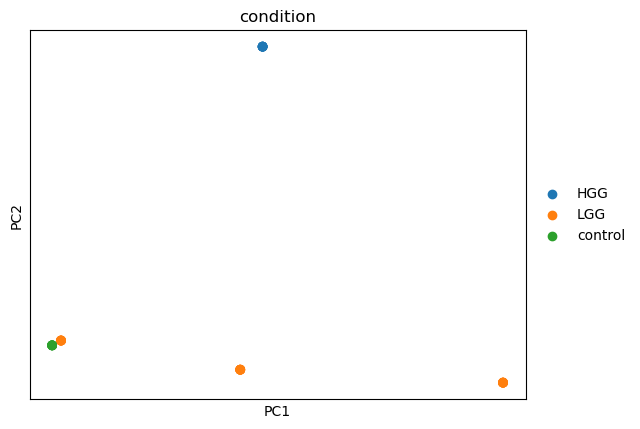

In [106]:
from IPython.display import Image, display
display(Image(filename='../plot/deg_lgg2.png'))

In [143]:
adata.obs.sample_id = adata.obs.sample_id.cat.reorder_categories(['Control', 'LGG_1',"LGG_2", "LGG_3", 'HGG'])

In [144]:
adata.obs.sample_id.unique()

['LGG_1', 'HGG', 'LGG_2', 'LGG_3', 'Control']
Categories (5, object): ['Control', 'LGG_1', 'LGG_2', 'LGG_3', 'HGG']

In [145]:
c_lgg = adata[adata.obs.sample_id != "HGG"] # 14000
c_hgg = adata[adata.obs.sample_id.isin(["Control", "HGG"])] # 7000
lgg_hgg = adata[adata.obs.sample_id != "Control"] # 20000

In [146]:
# create pseudobulk & replicates
def do_pseudobulk(adata):
    pseudobulk = []
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset.X.sum(axis = 0), 
                                var = sample_cell_subset.var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]
            if "LGG" in sample:
                condition = 'LGG'
            elif "HGG" in sample:
                condition = "HGG"
            else:
                condition = "control"
            rep_adata.obs['condition'] = condition
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['condition'],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.60 seconds.

Fitting dispersion trend curve...
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/pydeseq2/dds.py:590: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend()
... done in 0.24 seconds.

/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fitting MAP dispersions...
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=

Log2 fold change & Wald test p-value: condition control vs HGG
                       baseMean  log2FoldChange     lfcSE       stat  \
Xkr4                2870.140134        0.329406  0.029235  11.267419   
Gm1992                91.842739        0.617720  0.158268   3.903000   
Gm19938              172.189986        0.610182  0.115675   5.274968   
Rp1                    9.804800        3.422857  0.504370   6.786395   
Sox17                 63.355492        4.685891  0.247420  18.939003   
...                         ...             ...       ...        ...   
Csprs                  1.393760       -2.078730  1.959896  -1.060633   
ENSMUSG00000096808     0.139376        1.243194  2.113197   0.588300   
ENSMUSG00000095742     5.938631        3.270853  0.636169   5.141488   
ENSMUSG00000095041  3892.996525       -2.505392  0.046518 -53.858043   
Cas9-EGFP           2052.299813       -4.824645  0.133560 -36.123427   

                           pvalue           padj  
Xkr4                 

... done in 0.89 seconds.



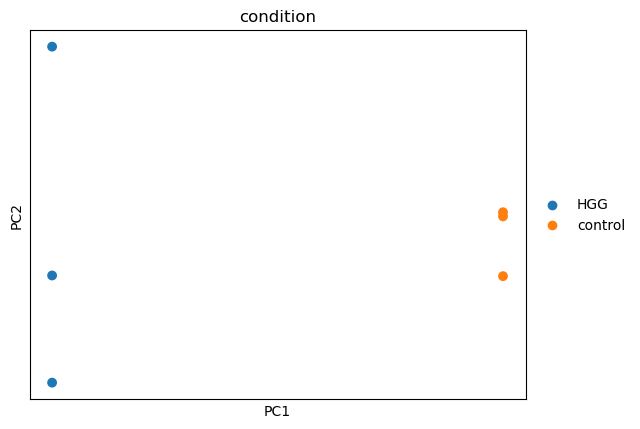

In [147]:
dds, de, fig = do_pseudobulk(c_hgg)

In [148]:
mapper = id_map(species='mouse')
def map_ids(gene):
    if gene in mapper.mapper.keys():
        return mapper.mapper[gene]
    else:
        return gene
de["Symbol"] = de.index.map(map_ids)

de = de[de.baseMean >= 10]
sigs = de[(de.padj < 0.05) & (abs(de.log2FoldChange) > 1)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
Sox17,63.355492,4.685891,0.247420,18.939003,5.441831e-80,4.455974e-79,Sox17
A930006A01Rik,22.275924,1.396385,0.304722,4.582482,4.594882e-06,1.035476e-05,A930006A01Rik
St18,9286.036583,5.665856,0.025995,217.959048,0.000000e+00,0.000000e+00,St18
Rrs1,836.571247,-1.280572,0.072557,-17.649084,1.034204e-69,7.710228e-69,Rrs1
Adhfe1,245.144244,2.488590,0.092678,26.852036,7.985314e-159,1.069060e-157,Adhfe1
...,...,...,...,...,...,...,...
Ddx3y,1033.830737,5.396618,0.072567,74.367285,0.000000e+00,0.000000e+00,Ddx3y
Gm47283,3721.388282,-1.701066,0.038154,-44.584802,0.000000e+00,0.000000e+00,Gm47283
mt-Nd3,5029.862502,1.121096,0.020548,54.560191,0.000000e+00,0.000000e+00,mt-Nd3
ENSMUSG00000095041,3892.996525,-2.505392,0.046518,-53.858043,0.000000e+00,0.000000e+00,AC149090.1


#### 2. GSEA
- manual or gene ontology

In [149]:
#### Gene ontology candidates
neural_progenitor_cell_maintenance = {
    "Neurogenesis": "GO:0022008",
    "Neuron fate commitment": "GO:0048663",
    "Neuron development": "GO:0048666"
}

glioma_and_tumor_development = {
    "Apoptotic process involved in morphogenesis": "GO:0010623",
    "Positive regulation of cell migration": "GO:0030335",
    "Negative regulation of cell proliferation": "GO:0008285"
}

stem_cell_maintenance_and_differentiation = {
    "Stem cell maintenance": "GO:0019827",
    "Stem cell differentiation": "GO:0048863",
    "Cell fate commitment": "GO:0045165"
}

cell_cycle_and_division = {
    "Cell cycle": "GO:0007049",
    "Cell division": "GO:0051301",
    "Chromosome segregation": "GO:0007059"
}

signal_transduction_pathways = {
    "Signal transduction": "GO:0007165",
    "Neurotrophin TRK receptor signaling pathway": "GO:0048011",
    "Smoothened signaling pathway": "GO:0007224"
}

microenvironment_interaction = {
    "Skeletal system development": "GO:0001501",
    "Regulation of locomotion": "GO:0040012",
    "Cell-cell signaling": "GO:0007267"
}

In [ ]:
# gene ontology
gp.get_library_name()

In [151]:
bm = Biomart()
h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [152]:
library = gp.get_library('GO_Biological_Process_2023')

In [153]:
h2m_dict = {}
for i, row in h2m.loc[:,["external_gene_name", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict[row['external_gene_name']] = row["mmusculus_homolog_associated_gene_name"]

gene_sets = {}
for term, genes in library.items():
    new_genes = []
    for gene in genes:
        if gene in h2m_dict:
            new_genes.append(h2m_dict[gene])
    gene_sets[term] = new_genes

In [154]:
rnk = de[['stat']].dropna().sort_values('stat', ascending=False)

In [155]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, min_size = 5, max_size = 1000, seed = 6, permutation_num=1000)

2024-05-16 01:13:32,713 [WARNING] Duplicated values found in preranked stats: 10.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [156]:
out = []
for term in list(pre_res.results):
    out.append([term, pre_res.results[term]['fdr'], pre_res.results[term]['es'], pre_res.results[term]['nes'],])
out_df = pd.DataFrame(out, columns=['term', 'fdr', 'Enrichment_Score', 'Normalized_Enrichment_Score', ]).sort_values('fdr').reset_index(drop=True)
out_df

,term,fdr,Enrichment_Score,Normalized_Enrichment_Score
0,"mRNA Splicing, Via Spliceosome (GO:0000398)",0.000000,-0.607888,-2.317625
1,Aerobic Electron Transport Chain (GO:0019646),0.000000,-0.754283,-2.423187
2,Cytoplasmic Translation (GO:0002181),0.000000,-0.941750,-3.064438
3,Translation (GO:0006412),0.000000,-0.802392,-3.104228
4,Gene Expression (GO:0010467),0.000000,-0.730959,-2.801388
...,...,...,...,...
4858,Mitochondrial Fusion (GO:0008053),0.999642,0.177114,0.381999
4859,Regulation Of Oxidoreductase Activity (GO:0051...,0.999709,0.182516,0.376189
4860,White Fat Cell Differentiation (GO:0050872),0.999914,0.216384,0.382632
4861,UDP-N-acetylglucosamine Biosynthetic Process (...,0.999954,0.202915,0.386169


In [157]:
def get_existing_terms(terms, **kwargs):
    result = {}
    for category, go_dict in kwargs.items():
        for term, go_id in go_dict.items():
            for s in terms:
                if term.lower() in s.lower():
                    result[s] = {
                        "Class": category,
                        "Subclass": term
                    }
    return result

terms = pre_res.res2d.Term
existing_terms = get_existing_terms(terms, 
                                    neural_progenitor_cell_maintenance=neural_progenitor_cell_maintenance,
                                    glioma_and_tumor_development=glioma_and_tumor_development,
                                    stem_cell_maintenance_and_differentiation=stem_cell_maintenance_and_differentiation,
                                    cell_cycle_and_division=cell_cycle_and_division,
                                    signal_transduction_pathways=signal_transduction_pathways,
                                    microenvironment_interaction=microenvironment_interaction)

len(existing_terms.keys())

121

{'Class': 'neural_progenitor_cell_maintenance', 'Subclass': 'Neurogenesis'}


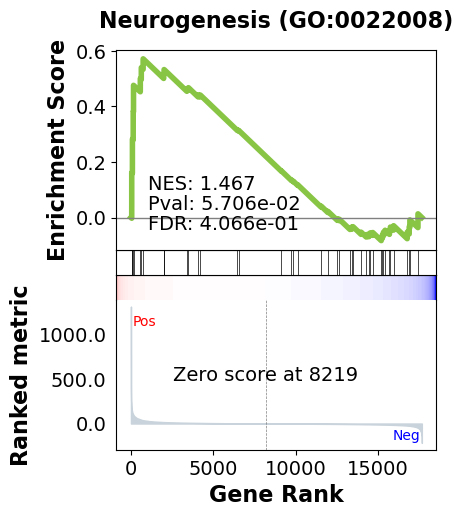

In [158]:
i = 0 # < 121
t = [k for k in existing_terms][i]
print(existing_terms[t])
axs = pre_res.plot(terms=t) 

- pdf에 2x2로 저장해서 나중에보자

In [ ]:
# save to pdf
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.image import AxesImage
import io

with PdfPages('../plot/gsea_hgg_vs_ctrl.pdf') as pdf:
    for i in range(0, len(existing_terms), 4):
        # Create a new figure with 2x2 subplots
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))
        
        # Flatten the axs array for easier indexing
        axs = axs.flatten()
        
        # Iterate over the next 4 terms
        for j in range(4):
            if i + j < len(existing_terms):
                # Get the term at index i + j
                t = [k for k in existing_terms][i + j]
                
                # Create a new figure to draw the plot
                plt.figure()
                pre_res.plot(terms=t)
                
                # Capture the plot as an image
                buf = io.BytesIO()
                plt.savefig(buf, format='png')
                plt.close()
                
                # Load the image into the corresponding subplot
                buf.seek(0)
                img = plt.imread(buf)
                axs[j].imshow(img)
                axs[j].set_title(f"Term: {existing_terms[t]['Class']} \n {existing_terms[t]['Subclass']}")
                axs[j].axis('off')
        
        # Adjust the spacing between subplots
        plt.tight_layout()
        
        # Save the figure to the PDF
        pdf.savefig(fig)
        
        # Close the figure to free up memory
        plt.close(fig)

#### 3. Heatmap

In [160]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_sigs = dds[:, sigs.index]

In [161]:
df_graph = pd.DataFrame(dds_sigs.layers['log1p'].T, index = dds_sigs.var_names, columns = dds_sigs.obs_names)
df_graph

,HGG-0,HGG-1,HGG-2,Control-0,Control-1,Control-2
Sox17,1.747247,1.747247,1.747247,4.811958,4.811958,4.811958
A930006A01Rik,2.585136,2.585136,2.585136,3.505160,3.505160,3.505160
St18,5.885420,5.885420,5.885420,9.809963,9.809963,9.809963
Rrs1,7.078555,7.078555,7.078555,6.192135,6.192135,6.192135
Adhfe1,4.319460,4.319460,4.319460,6.033423,6.033423,6.033423
...,...,...,...,...,...,...
Ddx3y,3.890704,3.890704,3.890704,7.611207,7.611207,7.611207
Gm47283,8.647013,8.647013,8.647013,7.468319,7.468319,7.468319
mt-Nd3,8.061265,8.061265,8.061265,8.838179,8.838179,8.838179
ENSMUSG00000095041,8.798014,8.798014,8.798014,7.062115,7.062115,7.062115


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


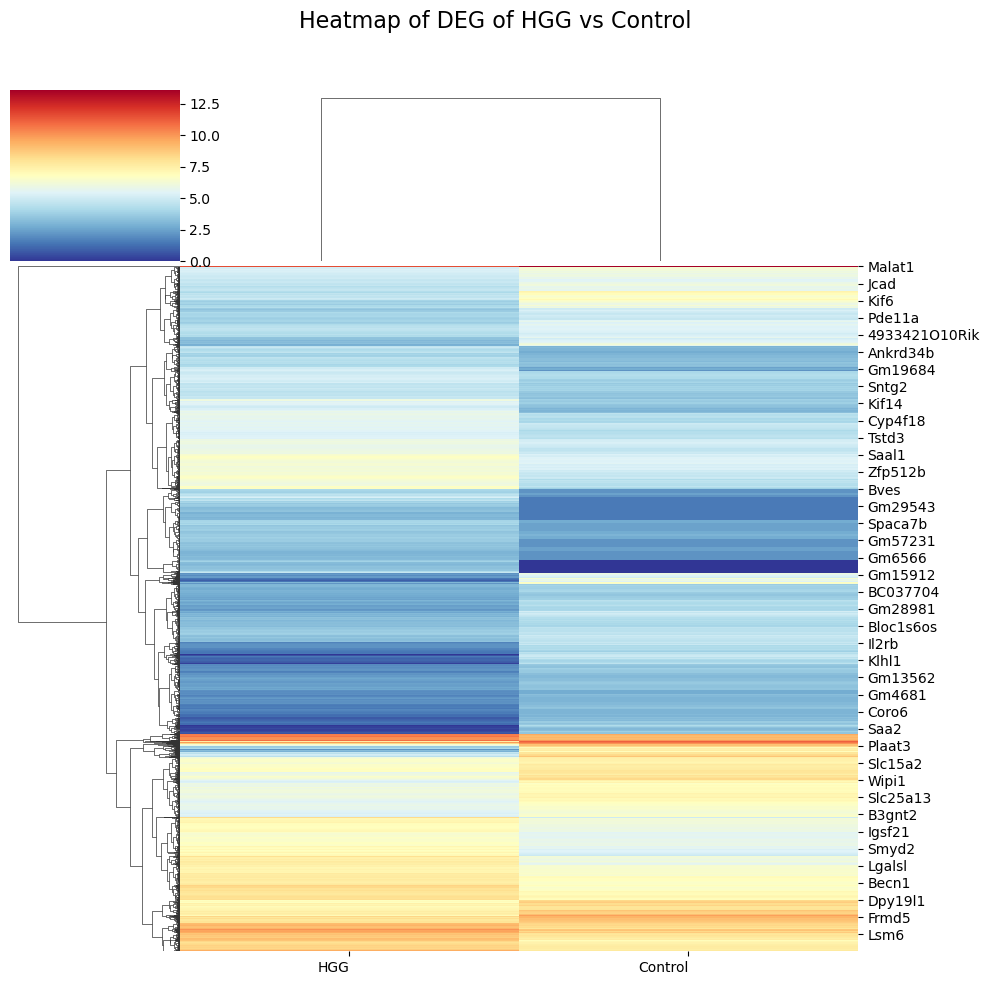

In [166]:
g = sns.clustermap(df_graph, cmap = "RdYlBu_r",  method='average') 
unique_labels = ["HGG", "Control"]
positions = [1.5, 4.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmap of DEG of HGG vs Control", x=0.5, ha='center', fontsize=16)
plt.show()

In [167]:
sigs_subset = sigs.iloc[:-8]
sigs_subset.tail(10)
dds_sigs_subset = dds[:, sigs.index]
df_graph_subset = pd.DataFrame(dds_sigs_subset.layers['log1p'].T, index = dds_sigs_subset.var_names, columns = dds_sigs_subset.obs_names)
df_graph_subset

,HGG-0,HGG-1,HGG-2,Control-0,Control-1,Control-2
Sox17,1.747247,1.747247,1.747247,4.811958,4.811958,4.811958
A930006A01Rik,2.585136,2.585136,2.585136,3.505160,3.505160,3.505160
St18,5.885420,5.885420,5.885420,9.809963,9.809963,9.809963
Rrs1,7.078555,7.078555,7.078555,6.192135,6.192135,6.192135
Adhfe1,4.319460,4.319460,4.319460,6.033423,6.033423,6.033423
...,...,...,...,...,...,...
Ddx3y,3.890704,3.890704,3.890704,7.611207,7.611207,7.611207
Gm47283,8.647013,8.647013,8.647013,7.468319,7.468319,7.468319
mt-Nd3,8.061265,8.061265,8.061265,8.838179,8.838179,8.838179
ENSMUSG00000095041,8.798014,8.798014,8.798014,7.062115,7.062115,7.062115


- 너무 차이 많은 gene들이 있어서 subset해도 결과는 똑같은듯

/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


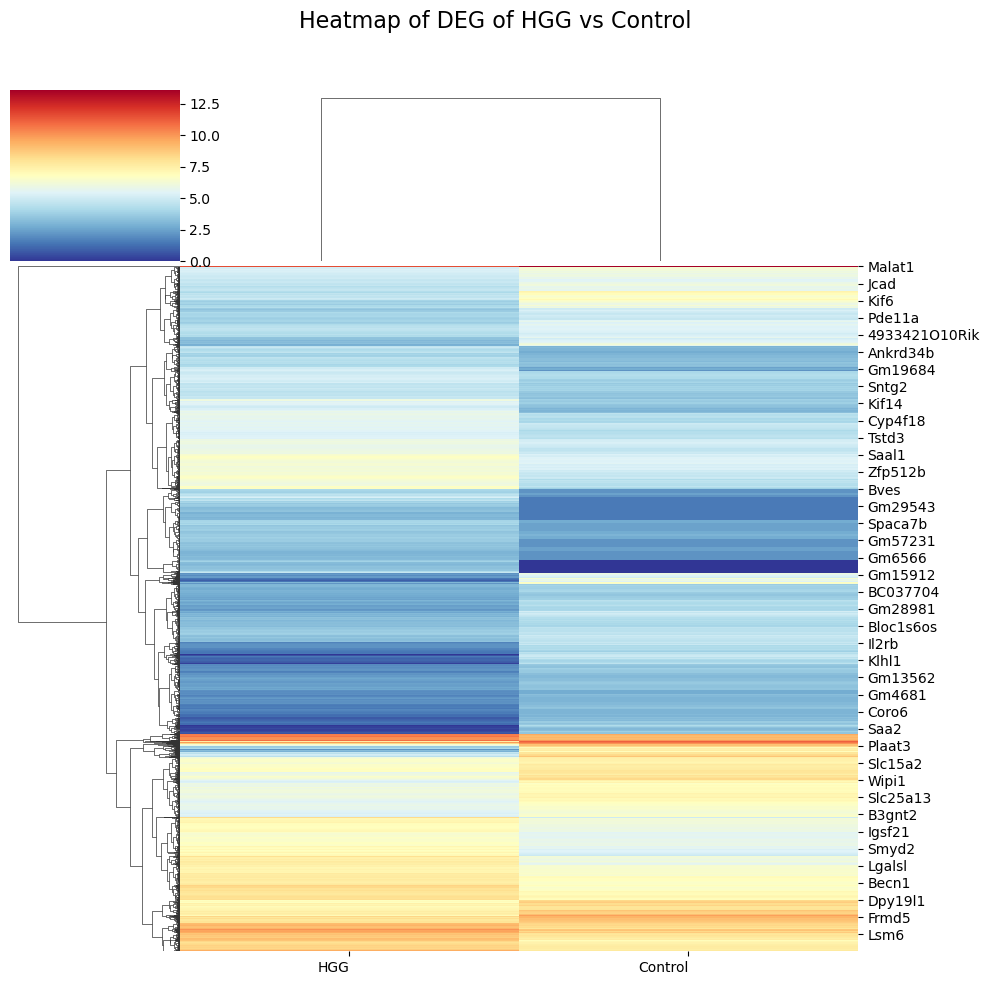

In [168]:
g = sns.clustermap(df_graph_subset, cmap = "RdYlBu_r",  method='average') 
unique_labels = ["HGG", "Control"]
positions = [1.5, 4.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmap of DEG of HGG vs Control", x=0.5, ha='center', fontsize=16)
plt.show()

- plot with markers

In [63]:
markers_from_paper = pd.read_csv('../astrocytoma_markers.csv')
for col in markers_from_paper.columns:
    markers_from_paper[col] = markers_from_paper[col].apply(lambda x:x.capitalize())
markers_from_paper = {cell : [m for m in mk if m in adata.var.index] for cell, mk in markers_from_paper.items()}
markers_from_paper.keys()

dict_keys(['Astro-like', 'Astrocytes', 'Cycling', 'Endothelial', 'Gradient', 'Microglia', 'Mixed', 'Neurons', 'Oligodendrocytes', 'OPC-like', 'Pericytes', 'RE', 'T Cell'])

- plot "OPC-like" markers

In [169]:
coi = "OPC-like"
mks = markers_from_paper[coi]
dds_sub = dds[:, sigs[sigs.index.isin(mks)].index] # res for DE
df_sub = pd.DataFrame(dds_sub.layers['log1p'].T, index = dds_sub.var_names, columns = dds_sub.obs_names)
df_sub

,HGG-0,HGG-1,HGG-2,Control-0,Control-1,Control-2
Tmeff2,8.621474,8.621474,8.621474,10.156387,10.156387,10.156387
Asic4,2.890587,2.890587,2.890587,3.700353,3.700353,3.700353
Sphkap,2.775871,2.775871,2.775871,4.895856,4.895856,4.895856
Brinp2,7.408082,7.408082,7.408082,6.091881,6.091881,6.091881
Tnr,9.990226,9.990226,9.990226,8.876473,8.876473,8.876473
Col20a1,6.837965,6.837965,6.837965,4.840713,4.840713,4.840713
Myt1,7.727431,7.727431,7.727431,6.242225,6.242225,6.242225
Sh3d19,9.138956,9.138956,9.138956,8.171372,8.171372,8.171372
Lhfpl3,10.901220,10.901220,10.901220,9.298452,9.298452,9.298452
Sez6l,7.230435,7.230435,7.230435,5.971335,5.971335,5.971335


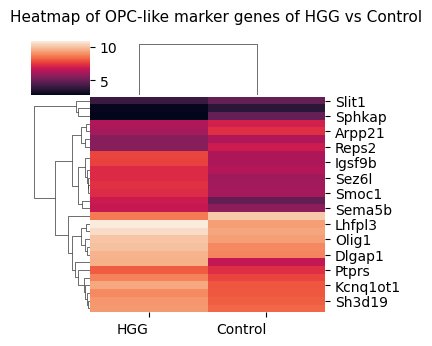

In [171]:
g = sns.clustermap(df_sub, method='average', figsize = (4,4))
unique_labels = ["HGG", "Control"]
positions = [1.5, 4.5]

g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks(positions)
g.ax_heatmap.set_xticklabels(unique_labels)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation = 0, ha="right")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Heatmap of OPC-like marker genes of HGG vs Control", x=0.5, ha='center', fontsize=11)
plt.show()

#### 4. Volcano plot
- pyDeSeq output

0s encountered for p value, imputing 1e-323
impute your own value if you want to avoid this


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/sanbomics/plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pvalue][df[pvalue] == 0] = 1e-323


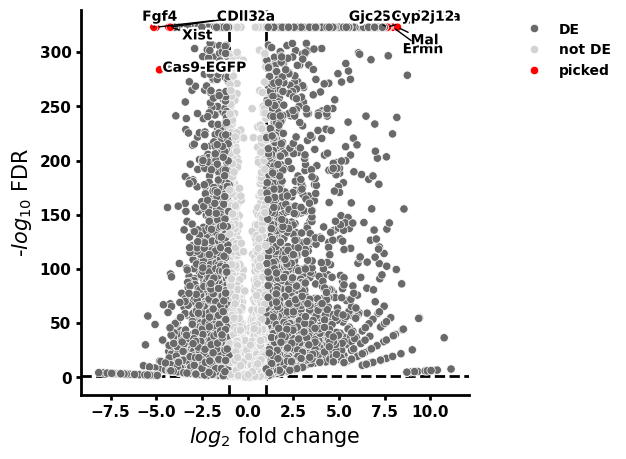

In [172]:
volcano(de, symbol="Symbol", log2fc_thresh = 1,  colors = ["dimgrey", "lightgrey", "red"])

0s encountered for p value, imputing 1e-323
impute your own value if you want to avoid this


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/sanbomics/plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pvalue][df[pvalue] == 0] = 1e-323


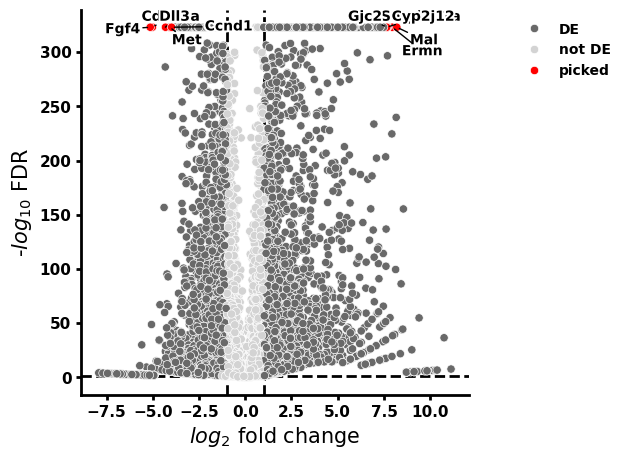

In [173]:
volcano(de.iloc[:-2000,:], symbol="Symbol", log2fc_thresh = 1,  colors = ["dimgrey", "lightgrey", "red"])

0s encountered for p value, imputing 1e-323
impute your own value if you want to avoid this


/Users/jiehoonk/micromamba/envs/deg/lib/python3.10/site-packages/sanbomics/plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pvalue][df[pvalue] == 0] = 1e-323


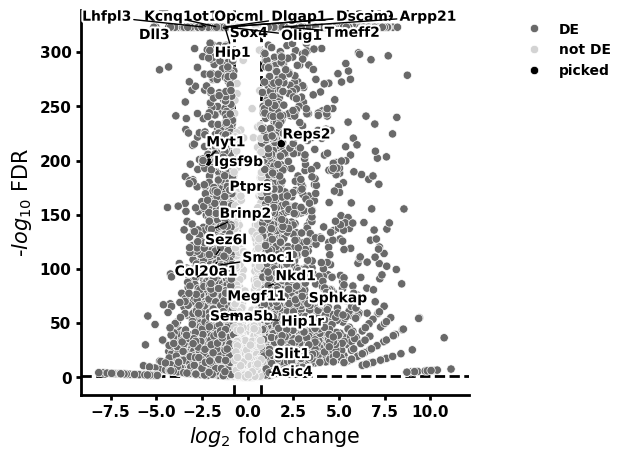

In [174]:
# OPC-like
volcano(de, symbol="Symbol", to_label = df_sub.index)